In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

#reading the data
data = pd.read_csv('data/all_data.csv', on_bad_lines='skip')
display(data)

### Grouping Field Labels and Types by ID

In this case, we will:
- Put all field labels in a list, as well as the field types.
- Group them by the form's `ID`.
- The data will be a form aggregate, containing:
  - A name
  - A list of field types
  - A list of field labels

In [21]:
# Remove all elements of type block.(maybe late include it)
indices_to_drop = data[data['elementtype'] == 'block'].index

# Drop those indices
data = data.drop(indices_to_drop)

# If the element is special the actual fieldtype is in specialtype
# We will exclude element types.

#none since logic to do it.
data['isspecial'] = data['elementtype'].apply(lambda x: 1 if x == 'special' else 0)

for index, row in data.iterrows():
    if row['isspecial'] == 1:
        if pd.notnull(row['fieldtype']):  # Check if 'fieldtype' is already filled
            print(f"Row {index}: 'fieldtype' already has a value before assigning 'specialtype'")
        else:
            # If 'fieldtype' is empty, assign the value from 'specialtype'
            data.at[index, 'fieldtype'] = row['specialtype']

#Drop non-relevant columns.
data = data.drop(columns=['Kunde','isspecial','elementtype', 'customname','fieldobjectid','fieldparentid','fieldparenttype','blocktype','fieldrelation','language','specialtype'])

#Lets group the data by customform (id) and include name and mape the structure.
grouped = data.groupby(['customform', 'name']).agg({
    'fieldtype': lambda x: list(x),  # Keep all field types as a list
    'fieldlabel': lambda x: ' | '.join(x)  # Concatenate field labels
}).reset_index()

# Step 2: Count occurrences of each field type for each customform
fieldtype_counts = data.groupby(['customform', 'fieldtype']).size().unstack(fill_value=0)

# Step 3: Combine the aggregated data with the counts
result = pd.merge(grouped, fieldtype_counts, on='customform', how='left')
display(result)

,customform,name,fieldtype,fieldlabel
0,770,Projektportefølje,"[autonum, created, createdby, relation, string...","[Projekt nr., Oprettet den, Oprettet af, Proje..."
1,775,Projektområde,[string],[Tekst]
2,876,Claims,"[userrelation, text, relation, text, createdby...","[Processor, Description of claim, Complaint ca..."
3,876,Kundereklamation,"[listselect, string, string, string, string, s...","[Vælg kunde, Gadenavn, Postnr, By, Telefonnumm..."
4,876,Reklamation,"[listselect, string, string, userrelation, rel...","[Vælg kunde, E-mail, Kontaktperson, Behandles ..."
...,...,...,...,...
854,2584010,Formularkatalog,"[createdby, created, layout_linebreak, changed...","[Oprettet af, Oprettet, Blank linje, Seneste æ..."
855,2584018,Formularkatalog - Kategori,[string],[Kategori]
856,2584251,Formularkatalog - Øvrige vurderinger,"[text, userrelation, relation, text]","[Hvad gør formularen god?, Vurderet af, Vurder..."
857,2584255,Formularkatalog - Vurderingsskala,[integer],[Vurdering]


### Word Embedding

We will create embeddings for the following:
- Name
- Field type list
- Field label list

In [23]:
 #Combine the text into a single list for Word2Vec
# Ensure all entries are strings
all_texts = [result['name'].tolist()] + result['fieldtype'].tolist() + result['fieldlabel'].tolist()

# Flatten the list of lists to a single list of strings
all_texts = [str(item) for sublist in all_texts for item in sublist]

# Tokenize the text into lists of words
tokenized_texts = [text.split() for text in all_texts]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Create Embeddings
def get_embedding(text):
    # If the input is a list, join it to form a single string
    if isinstance(text, list):
        # Convert all elements to string and filter out None or NaN values
        text = ' '.join(str(item) for item in text if pd.notna(item))
    
    # Handle case where text might still be empty after filtering
    if not text:
        return [0] * model.vector_size

    # Tokenize the text
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) == 0:  # In case no words are in the model
        return [0] * model.vector_size
    
    # Average the word vectors
    return np.mean(word_vectors, axis=0)

# Generate embeddings for each column
result['name_embedding'] = result['name'].apply(get_embedding)
result['fieldtype_embedding'] = result['fieldtype'].apply(get_embedding)
result['fieldlabel_embedding'] = result['fieldlabel'].apply(get_embedding)

# Display the results
display(result[['name', 'fieldtype', 'fieldlabel', 'name_embedding', 'fieldtype_embedding', 'fieldlabel_embedding']])

,name,fieldtype,fieldlabel,name_embedding,fieldtype_embedding,fieldlabel_embedding
0,Projektportefølje,"[autonum, created, createdby, relation, string...","[Projekt nr., Oprettet den, Oprettet af, Proje...","[0.0005039418, 0.0034946073, 0.007462857, -0.0...","[-0.0012538005, 0.00010913042, 0.0046849493, -...","[-0.024251522, 0.0533292, -0.008943403, 0.0195..."
1,Projektområde,[string],[Tekst],"[0.009846041, 0.0040912116, -0.004202361, -0.0...","[-0.00053622725, 0.00023643136, 0.0051033497, ...","[-0.0039170934, -0.0056719054, 0.008729148, 0...."
2,Claims,"[userrelation, text, relation, text, createdby...","[Processor, Description of claim, Complaint ca...","[-0.0005890343, 0.009813949, 0.0011415038, -0....","[-0.004121247, 0.0023910357, -0.0005852394, 0....","[-0.022106808, 0.05075571, -0.008654205, 0.016..."
3,Kundereklamation,"[listselect, string, string, string, string, s...","[Vælg kunde, Gadenavn, Postnr, By, Telefonnumm...","[-0.009465281, 0.0015580134, 0.007251058, 0.00...","[-0.0015204903, 0.0010328852, 0.0015221328, 0....","[-0.03576425, 0.07834387, -0.012782207, 0.0286..."
4,Reklamation,"[listselect, string, string, userrelation, rel...","[Vælg kunde, E-mail, Kontaktperson, Behandles ...","[-0.018458912, 0.030160347, -0.0061435117, 0.0...","[-0.0024898127, 0.0020912685, 0.0016482468, 0....","[-0.0381305, 0.08503682, -0.011655269, 0.02979..."
...,...,...,...,...,...,...
854,Formularkatalog,"[createdby, created, layout_linebreak, changed...","[Oprettet af, Oprettet, Blank linje, Seneste æ...","[0.0023317975, 0.009151247, -0.0040824916, 0.0...","[-0.003010842, 0.0006867785, 0.0007540427, 0.0...","[-0.043777846, 0.09804075, -0.015481856, 0.033..."
855,Formularkatalog - Kategori,[string],[Kategori],"[-0.077861086, 0.16682637, -0.02413045, 0.0548...","[-0.00053622725, 0.00023643136, 0.0051033497, ...","[-0.00761241, 0.004292996, -0.0007100178, 0.00..."
856,Formularkatalog - Øvrige vurderinger,"[text, userrelation, relation, text]","[Hvad gør formularen god?, Vurderet af, Vurder...","[-0.057688434, 0.13024549, -0.02141289, 0.0413...","[-0.004809586, 0.0013699026, 0.003256719, 0.00...","[-0.028607866, 0.06820049, -0.010963418, 0.018..."
857,Formularkatalog - Vurderingsskala,[integer],[Vurdering],"[-0.073312394, 0.1688184, -0.022435317, 0.0529...","[-0.0033387006, -0.006891975, 0.0064954115, 0....","[-0.010152344, 0.0087729385, -0.008761226, 0.0..."


### Dimensionality Reduction

After combining the embeddings we obtained, we will fit them to t-SNE and look for patterns and similarities.


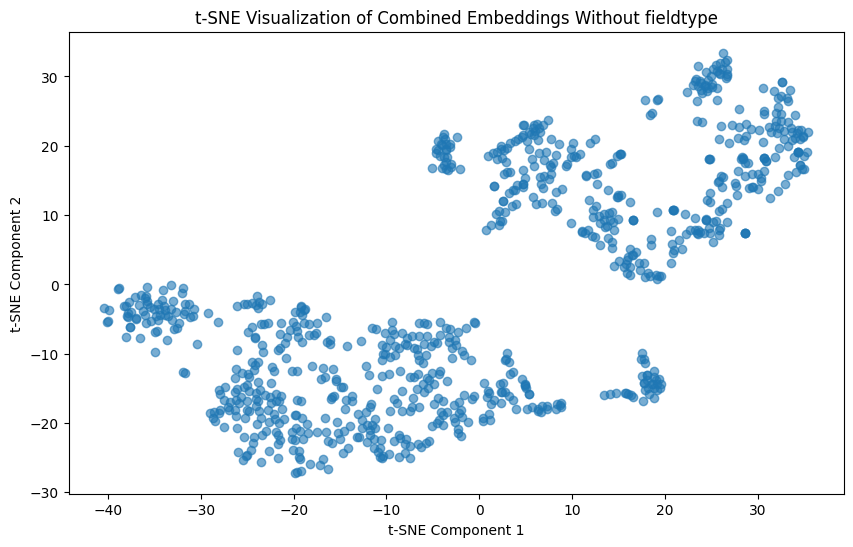

In [5]:
combined_embeddings = np.array([
    np.concatenate((row['name_embedding'], row['fieldlabel_embedding']))
    for _, row in result.iterrows()
])
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(combined_embeddings)
# Reduce the dimensionality of the combined embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(scaled_embeddings)

# Step 2: Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], alpha=0.6)
plt.title('t-SNE Visualization of Combined Embeddings Without fieldtype')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [6]:
# Combine all embeddings into a single array for clustering
combined_embeddings = np.array([
    np.concatenate((row['name_embedding'], row['fieldtype_embedding'], row['fieldlabel_embedding']))
    for _, row in result.iterrows()
])

print(combined_embeddings.shape)

scaler = StandardScaler() 
scaled_embeddings = scaler.fit_transform(combined_embeddings)

(859, 300)


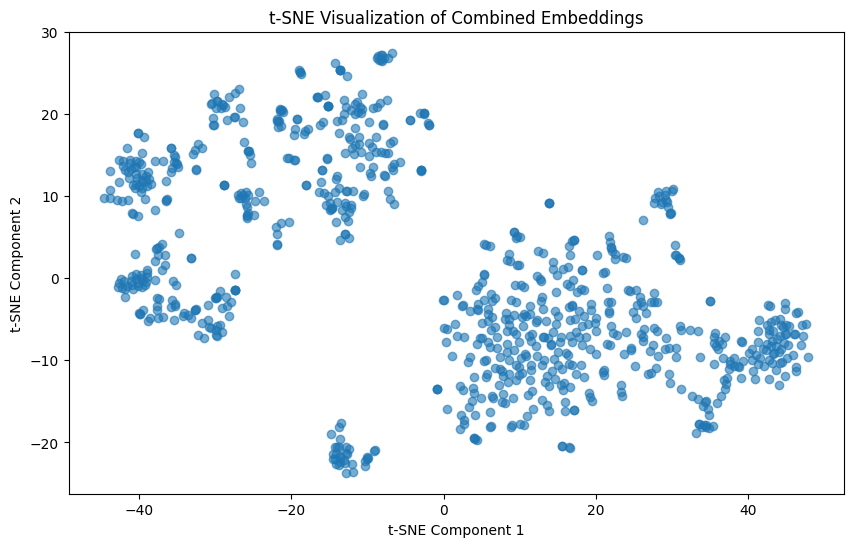

In [7]:


# Reduce the dimensionality of the combined embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(scaled_embeddings)

# Step 2: Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], alpha=0.6)
plt.title('t-SNE Visualization of Combined Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


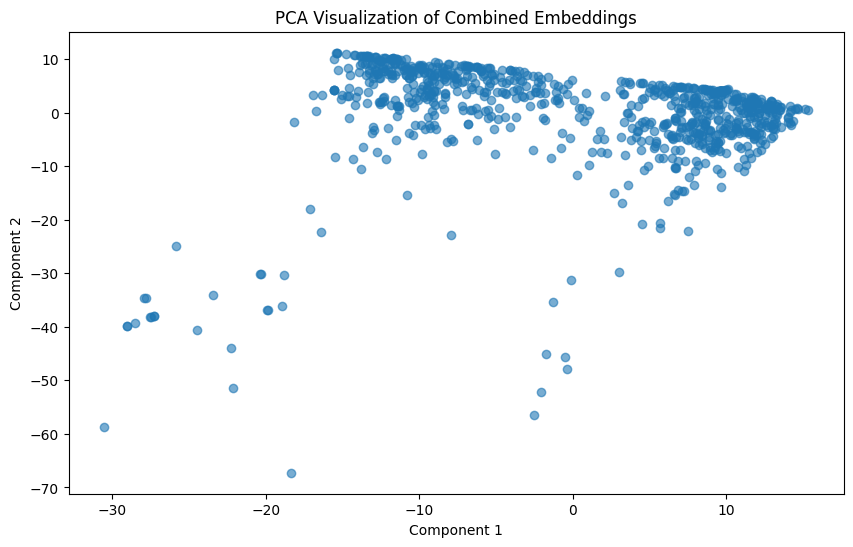

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_embeddings)

# Step 2: Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.6)
plt.title('PCA Visualization of Combined Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

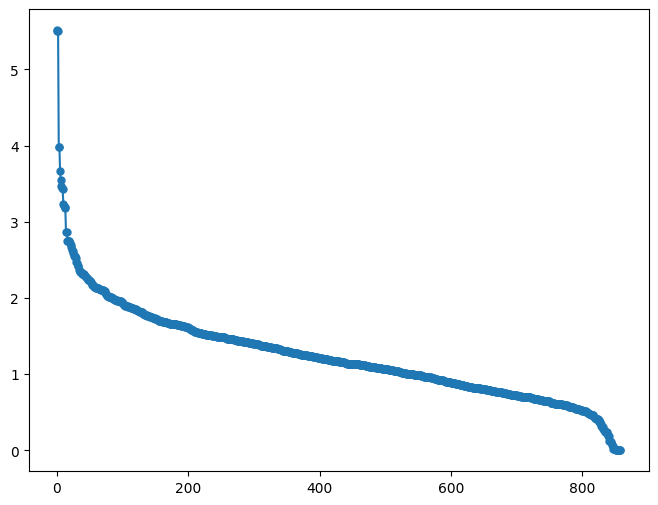

In [9]:
def calculate_k_distance(X,k):
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i,:]-X[j,:]))
        dist.sort()
        k_distance.append(dist[k])
    k_distance.sort(reverse=True)
    return k_distance

k = 3
k_distances = calculate_k_distance(reduced_embeddings_tsne,k)
plt.figure(figsize=(8,6))
plt.plot(range(len(reduced_embeddings_tsne)),k_distances, markersize=5, marker='o', linestyle='-')
plt.show()

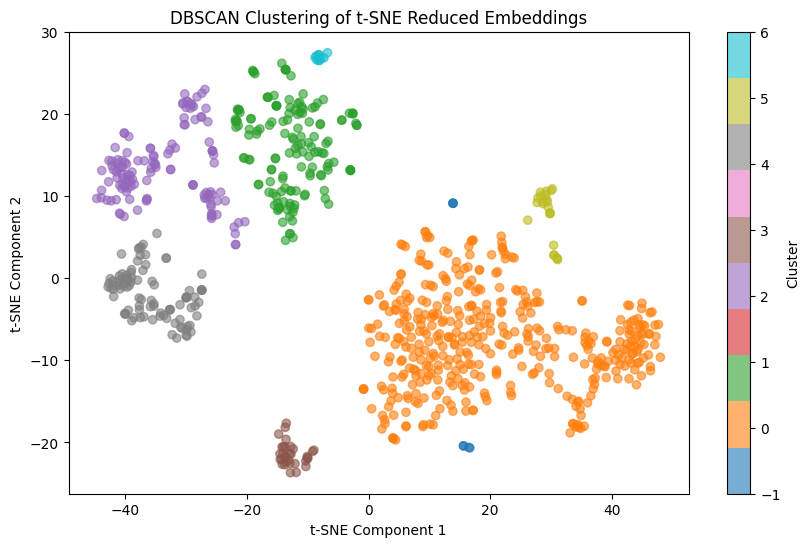

In [10]:

dbscan = DBSCAN(eps=4.1, min_samples=5)  # You can adjust eps and min_samples
clusters = dbscan.fit_predict(reduced_embeddings_tsne)

# Step 3: Plot the DBSCAN Clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.title('DBSCAN Clustering of t-SNE Reduced Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

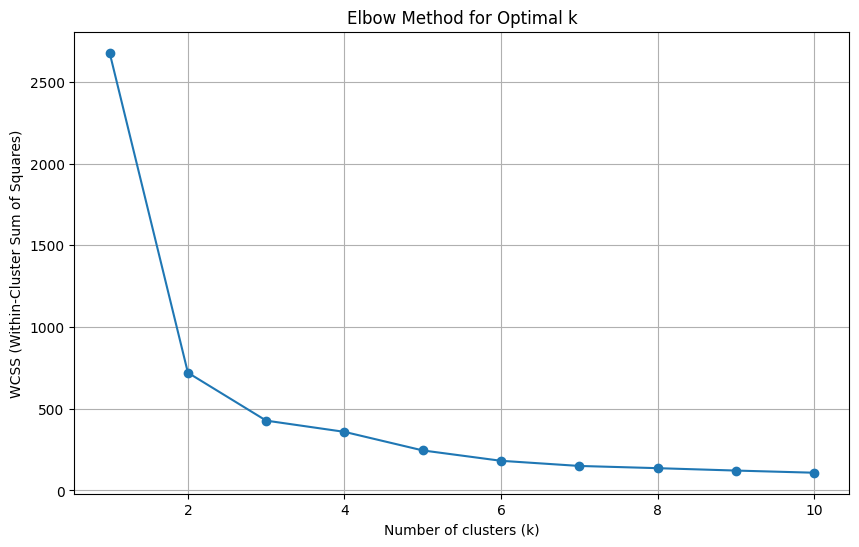

In [12]:


# Step 1: Calculate WCSS for a range of k values
wcss = []
max_k = 10  # You can adjust this limit based on your data
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_embeddings)  # Use the combined embeddings from earlier
    wcss.append(kmeans.inertia_)  # WCSS is stored in inertia_

# Step 2: Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid()
plt.show()


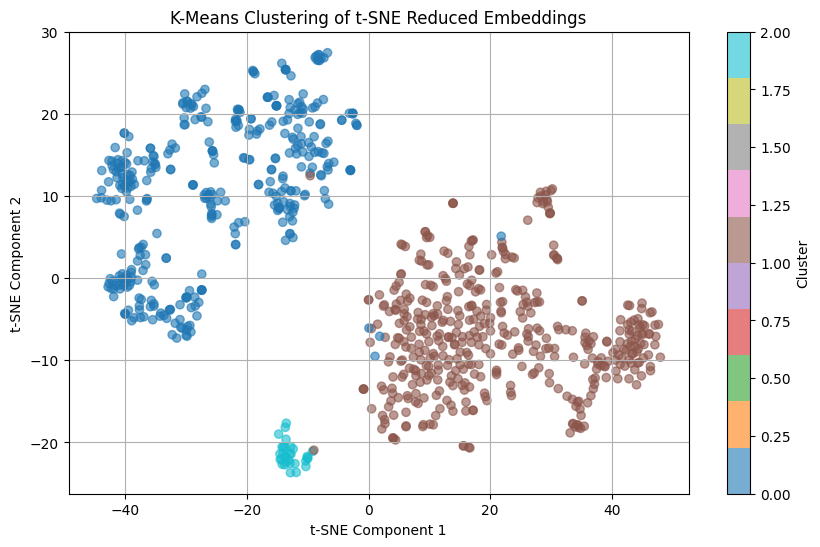

In [13]:
n_clusters = 3  # You can adjust this based on your needs
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict clusters
result['cluster'] = kmeans.fit_predict(combined_embeddings)

# Step 2: Visualize the results with t-SNE
# Assuming you already have reduced_embeddings_tsne from earlier
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=result['cluster'], cmap='tab10', alpha=0.6)
plt.title('K-Means Clustering of t-SNE Reduced Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

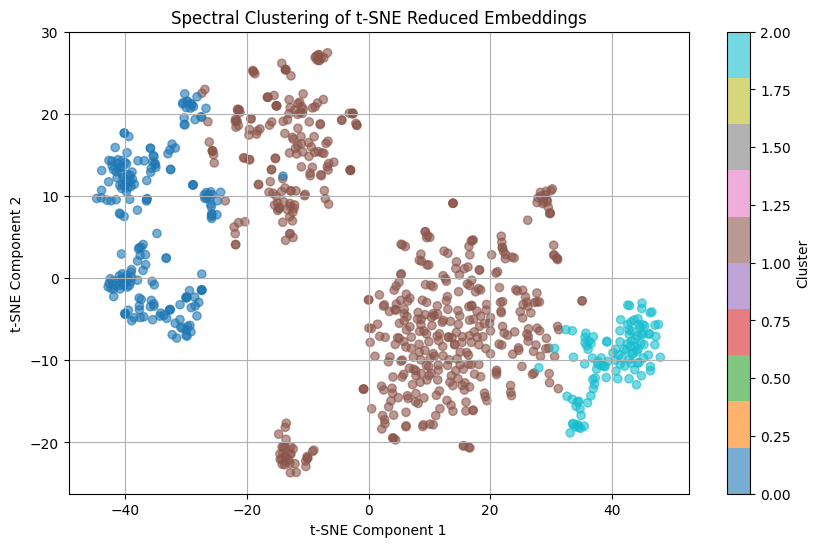

In [14]:

n_clusters = 3  
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
result['spectral_cluster'] = spectral_clustering.fit_predict(scaled_embeddings)

# Step 5: Plot t-SNE results colored by spectral cluster
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], 
            c=result['spectral_cluster'], cmap='tab10', alpha=0.6)
plt.title('Spectral Clustering of t-SNE Reduced Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()
